In [1]:
# Executing this cell does some magic
%load_ext autoreload
%autoreload 2

In [2]:
import sys
# Add the `src` folder to the system path
src_path = '../src' # Replace with the actual path to the `src` folder
sys.path.append(src_path)

In [3]:
# Required imports
import pandas as pd
import torch
from torch.utils.data import DataLoader
import os
import numpy as np

# Costum imports
from dataset.rating_dataset import preprocess_data, RatingDataset
from dataset.anime_data import AnimeData
from eval.evaluate import evaluate_mse

from models.genre_baseline import GenreBaselineModel
from models.content_based_recommender import ContentBasedRecommender

## Step 1: Preprocess Data

We'll get `train_dataset`, `val_dataset`, and `test_dataset` using our `preprocess_data` function.


In [4]:
train_dataset, val_dataset, test_dataset = preprocess_data(
    filepath='../data/raw/animelist.csv',
    user_range=10000,  # For example, limit to first 10k users
    include_watching_status=False,
    include_watched_episodes=False,
    zero_strategy='average',
    random_state=42,
    save_interaction_matrix=True
)

len_train = len(train_dataset)
len_val = len(val_dataset)
len_test = len(test_dataset)

print(f"Training samples: {len_train}, Validation samples: {len_val}, Test samples: {len_test}")

Training samples: 2600126, Validation samples: 325016, Test samples: 325016


In [5]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Step 2: Train the Model


It took me about 2 hrs to train the model for 50 epochs on my macbook.

In [17]:
anime_data = pd.read_csv('../data/raw/anime.csv')
model = ContentBasedRecommender(anime_data=anime_data)
model.fit(train_dataset.data)


/Users/kevinhuang/Desktop/Fall_2024/ML/ML_final_project/notebooks/../src/models/content_based_recommender.py:64: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Season'].fillna(df['Season'].mode()[0], inplace=True)
/Users/kevinhuang/Desktop/Fall_2024/ML/ML_final_project/notebooks/../src/models/content_based_recommender.py:65: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never w

3011
Epoch 1/50, Train Loss: 1.8331, Val Loss: 1.6750
Model and parameters saved to ../data/models/best_model.pth.
New best model saved with Val Loss: 1.6750
Epoch 2/50, Train Loss: 1.6218, Val Loss: 1.5570
Model and parameters saved to ../data/models/best_model.pth.
New best model saved with Val Loss: 1.5570
Epoch 3/50, Train Loss: 1.5210, Val Loss: 1.4682
Model and parameters saved to ../data/models/best_model.pth.
New best model saved with Val Loss: 1.4682
Epoch 4/50, Train Loss: 1.4409, Val Loss: 1.4238
Model and parameters saved to ../data/models/best_model.pth.
New best model saved with Val Loss: 1.4238
Epoch 5/50, Train Loss: 1.3825, Val Loss: 1.3596
Model and parameters saved to ../data/models/best_model.pth.
New best model saved with Val Loss: 1.3596
Epoch 6/50, Train Loss: 1.3371, Val Loss: 1.3366
Model and parameters saved to ../data/models/best_model.pth.
New best model saved with Val Loss: 1.3366
Epoch 7/50, Train Loss: 1.3040, Val Loss: 1.3117
Model and parameters saved t

In [23]:
print(model.training_losses)
print(model.validation_losses)

[1.8331495759067076, 1.6218437960998304, 1.521048729500598, 1.4409420544400475, 1.3824791782533121, 1.3370673799482609, 1.3040440194918834, 1.2754937650613283, 1.2538169917601227, 1.234545836440011, 1.219558883880687, 1.2066203091480063, 1.1939000130753512, 1.1840316591621145, 1.1753467156035402, 1.167846090453991, 1.1596203662594455, 1.1534706310955183, 1.1464896691899746, 1.1411203030610757, 1.1351916481835687, 1.1314282137010387, 1.1270618227381493, 1.1220485978892611, 1.118346728041867, 1.114866181670048, 1.111911906348547, 1.10819240584558, 1.1056857548372552, 1.1026960722407235, 1.100103768137367, 1.0974460408579598, 1.0944399613039821, 1.092986827375485, 1.0904611167248286, 1.0882122332567548, 1.0866085637026495, 1.0842773016154823, 1.0829120500415956, 1.0805438672158112, 1.0785388002600793, 1.0774575756888465, 1.0752961516296122, 1.0741591093399498, 1.0720461853454386, 1.071086642351079, 1.0691287138676184, 1.0680615007383487, 1.0672298678351868]
[1.674971778030711, 1.556995516

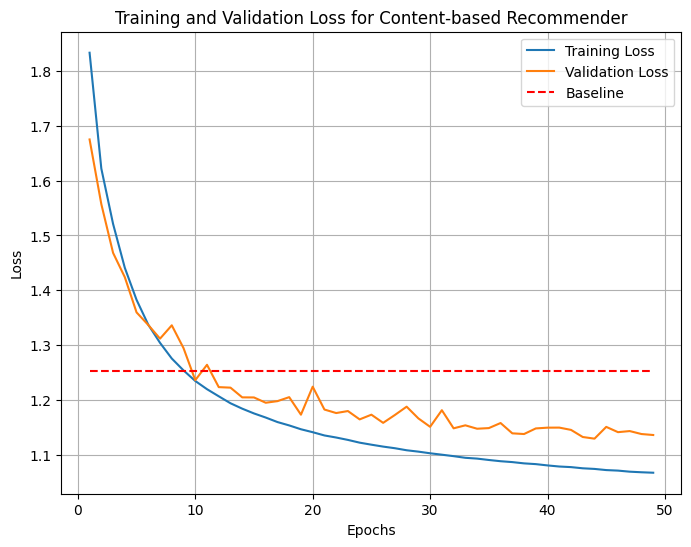

In [28]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(model.training_losses) + 1))

baseline = [1.2525] * len(epochs)

# Plotting the graph
plt.figure(figsize=(8, 6))
plt.plot(epochs, model.training_losses, label='Training Loss')
plt.plot(epochs, model.validation_losses, label='Validation Loss')
plt.plot(epochs, baseline, label='Baseline', linestyle='--', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Content-based Recommender')
plt.legend()
plt.grid(True)
plt.show()

## Step 3: Evaluate Model


In [18]:
# Load model
model_path = '../data/models/best_model.pth'
best_model = ContentBasedRecommender(anime_data=anime_data)
best_model.load_model_and_params(path=model_path)

Model and parameters loaded from ../data/models/best_model.pth.


In [19]:
# Test predictions
val_df = val_dataset.data
sample = val_df.sample(5, random_state=42)

user_ids = torch.tensor(sample['user_id'].values, dtype=torch.long)
item_ids = torch.tensor(sample['anime_id'].values, dtype=torch.long)
actual_ratings = sample['rating'].values

predictions = best_model(user_ids, item_ids)

for u, i, actual, pred in zip(user_ids, item_ids, actual_ratings, predictions):
    print(f"User {u.item()}, Item {i.item()} | Actual: {actual}, Predicted: {pred.item()}")


User 9675, Item 8516 | Actual: 7.0, Predicted: 7.80448579788208
User 7364, Item 41930 | Actual: 6.0, Predicted: 6.202725887298584
User 3470, Item 38422 | Actual: 7.3391442155309035, Predicted: 7.897365570068359
User 1504, Item 7311 | Actual: 9.0, Predicted: 8.716400146484375
User 657, Item 883 | Actual: 5.0, Predicted: 7.328073978424072


In [21]:
# Evaluation
val_mse = evaluate_mse(best_model, val_loader, device='cpu')
test_mse = evaluate_mse(best_model, test_loader, device='cpu')

print("Validation MSE:", val_mse)
print("Test MSE:", test_mse)

Validation MSE: 1.1282548351432442
Test MSE: 1.1339918130505202
